# Naive Bayesを使った文書分類
https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# originalデータを読み込み
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# subm = pd.read_csv('sample_submission.csv')

#前処理済みのデータを読み込み
train = pd.read_csv('train_preprocessing_upper_allfeature.csv')
del train['new_comment_text']
test = pd.read_csv('test_preprocessing_upper_allfeature.csv')
del test['new_comment_text']
subm = pd.read_csv('sample_submission.csv')

#元データ読み込み
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d ' aww ! he matches this background colour i...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man , i am really not trying to edit war ...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" more i can not make any real suggestions o...",0,0,0,0,0,0
4,0001d958c54c6e35,"you , sir , are my hero . any chance you re...",0,0,0,0,0,0


In [2]:
#データ確認
test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you ' ...
1,0000247867823ef7,= = from RFC = = the title is fine as it...
2,00013b17ad220c46,""" = = sources = = * zawe ashton on l..."
3,00017563c3f7919a,": if you have a look back at the source , th..."
4,00017695ad8997eb,i do not anonymously edit articles at all .


In [3]:
#データ確認
subm.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [4]:
#文字数の取得
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(419.6915657667143, 629.8997989218074, 14855.0)

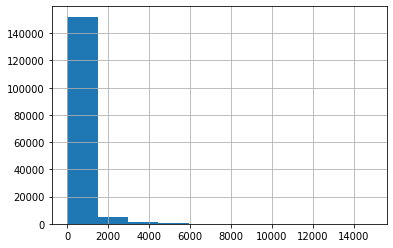

In [5]:
#文字数の確認
lens.hist()

In [6]:
#none列を作成
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,d ' aww ! he matches this background colour i...,0,0,0,0,0,0,1
2,000113f07ec002fd,"hey man , i am really not trying to edit war ...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,""" more i can not make any real suggestions o...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"you , sir , are my hero . any chance you re...",0,0,0,0,0,0,1


In [7]:
#欠損除去（不要？）
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [8]:
#記号の前後にスペースを入れるtokenizeを設定
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [9]:
#確認用
tokenize(train[COMMENT][16])[:5]

['bye', '!', 'do', 'not', 'look']

In [10]:
#上のtokenize解説
#punctuationは記号の集まり
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
#上のtokenize解説
#\1の使い方
pattern = re.compile(r'(今日)')
str1 = "こんにちは。今日は晴れですね。"

#patternに一致したものの前後に空白を入れる
sub1 = pattern.sub(r' \1 ', str1)
print(sub1)

こんにちは。 今日 は晴れですね。


In [12]:
#tfidfの作成
n = train.shape[0]

#ngram_range : unigram and bigram
#min_df : 3回以下しか出ない単語は無視
#max_df : proportion of documents
#strip_accents : 'unicode' 世界中の文字を扱う
#use_idf=1 : 単語の希少度で重みを付ける
#https://komei22.hatenablog.com/entry/2019/08/27/124824
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [13]:
vec.vocabulary_

{'explanation': 152622,
 'why': 403004,
 'the': 352958,
 'edits': 143109,
 'made': 227266,
 'under': 383256,
 'my': 242914,
 'username': 387686,
 'hardcore': 178391,
 'metallica': 235353,
 'fan': 155175,
 'were': 398445,
 'reverted': 308546,
 '?': 39012,
 'they': 366527,
 'not': 251301,
 'vandalisms': 389222,
 ',': 11635,
 'just': 212821,
 'closure': 112551,
 'on': 264518,
 'some': 330427,
 'gas': 169120,
 'after': 53258,
 'i': 190449,
 'voted': 393046,
 'at': 80354,
 'new': 247798,
 'york': 412448,
 'dolls': 138432,
 'fac': 153653,
 '.': 21784,
 'and': 61805,
 'please': 283957,
 'do': 137350,
 'remove': 304671,
 'template': 348163,
 'from': 165727,
 'talk': 346451,
 'page': 275396,
 'since': 326409,
 'am': 58678,
 'retired': 308056,
 'now': 254793,
 '89': 35489,
 '205': 32270,
 '38': 33633,
 '27': 32857,
 'explanation why': 152667,
 'why the': 403142,
 'the edits': 356111,
 'edits made': 143202,
 'made under': 227451,
 'under my': 383368,
 'my username': 244302,
 'hardcore metallica':

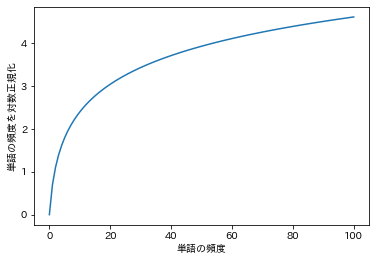

In [14]:
#tfidfの補足
#sublinear_tf=1 とは
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#https://en.wikipedia.org/wiki/Tf%E2%80%93idf

import matplotlib.pyplot as plt
import japanize_matplotlib
a=np.linspace(0,100,100)
b=np.log(1+a)
plt.xlabel('単語の頻度')
plt.ylabel('単語の頻度を対数正規化')
plt.plot(a,b)

In [15]:
#単語の確認
vec.vocabulary_

{'explanation': 152622,
 'why': 403004,
 'the': 352958,
 'edits': 143109,
 'made': 227266,
 'under': 383256,
 'my': 242914,
 'username': 387686,
 'hardcore': 178391,
 'metallica': 235353,
 'fan': 155175,
 'were': 398445,
 'reverted': 308546,
 '?': 39012,
 'they': 366527,
 'not': 251301,
 'vandalisms': 389222,
 ',': 11635,
 'just': 212821,
 'closure': 112551,
 'on': 264518,
 'some': 330427,
 'gas': 169120,
 'after': 53258,
 'i': 190449,
 'voted': 393046,
 'at': 80354,
 'new': 247798,
 'york': 412448,
 'dolls': 138432,
 'fac': 153653,
 '.': 21784,
 'and': 61805,
 'please': 283957,
 'do': 137350,
 'remove': 304671,
 'template': 348163,
 'from': 165727,
 'talk': 346451,
 'page': 275396,
 'since': 326409,
 'am': 58678,
 'retired': 308056,
 'now': 254793,
 '89': 35489,
 '205': 32270,
 '38': 33633,
 '27': 32857,
 'explanation why': 152667,
 'why the': 403142,
 'the edits': 356111,
 'edits made': 143202,
 'made under': 227451,
 'under my': 383368,
 'my username': 244302,
 'hardcore metallica':

In [16]:
#ベイズ式の定義
def pr(y_i, y,alpha):
    p = x[y==y_i].sum(0)
    return (p+alpha) / ((y==y_i).sum()+alpha) #ここの+1が論文のα（パラメータ）

x = trn_term_doc
test_x = test_term_doc

In [17]:
from sklearn.model_selection import GridSearchCV
alpha=1

#grid_search関数を定義
def grid_search(label,grid):
    y = train[label].values
    # 分子=toxicが1の文書にその単語が何回出るか/toxicが1の文書に出てくる全単語の総数
    # 分母=toxicが0の文書にその単語が何回出るか/toxicが0の文書に出てくる全単語の総数
    # つまり r は 文書がtoxicに所属する場合に、その単語の出てきやすさを表す

    r = np.log(pr(1,y,alpha) / pr(0,y,alpha)) 
    print('r:',r)
    print('r.shape:',r.shape) #rのshapeを確認
    
    #logistic回帰をインスタンス化
    logreg=LogisticRegression(dual=True, penalty='l2',solver='liblinear')
    #GridSearchCVをインスタンス化
    logreg_cv=GridSearchCV(logreg,grid,cv=3,scoring="roc_auc",verbose=10)
    
    x_nb = x.multiply(r) #Tfidf（単語の頻度）にr（toxicに所属する場合の単語のでやすさ）をかける
    print('x_nb.shape',x_nb.shape)
    
    return logreg_cv.fit(x_nb, y) #x_nbでgrid_searchを実施

In [18]:
#toxicだけ別の範囲でGridSearch
grid1={"C":np.arange(1.5,2.5,0.05)}
model1=grid_search('toxic',grid1)

r: [[1.16349325 2.07609854 0.19934149 ... 2.03089828 0.84376848 0.84376848]]
r.shape: (1, 419411)
x_nb.shape (159571, 419411)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1.5 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=1.5, score=0.980, total=  19.9s
[CV] C=1.5 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s remaining:    0.0s


[CV] ............................... C=1.5, score=0.979, total=  18.3s
[CV] C=1.5 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.2s remaining:    0.0s


[CV] ............................... C=1.5, score=0.981, total=  22.2s
[CV] C=1.55 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV] .............................. C=1.55, score=0.980, total=  20.8s
[CV] C=1.55 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV] .............................. C=1.55, score=0.979, total=  19.4s
[CV] C=1.55 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s


[CV] .............................. C=1.55, score=0.981, total=  23.7s
[CV] C=1.6 ...........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s


[CV] ............................... C=1.6, score=0.980, total=  21.8s
[CV] C=1.6 ...........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.4min remaining:    0.0s


[CV] ............................... C=1.6, score=0.979, total=  19.6s
[CV] C=1.6 ...........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s


[CV] ............................... C=1.6, score=0.981, total=  21.9s
[CV] C=1.6500000000000001 ............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.1min remaining:    0.0s


[CV] ................ C=1.6500000000000001, score=0.980, total=  24.8s
[CV] C=1.6500000000000001 ............................................
[CV] ................ C=1.6500000000000001, score=0.979, total=  24.7s
[CV] C=1.6500000000000001 ............................................
[CV] ................ C=1.6500000000000001, score=0.981, total=  24.0s
[CV] C=1.7000000000000002 ............................................
[CV] ................ C=1.7000000000000002, score=0.981, total=  25.5s
[CV] C=1.7000000000000002 ............................................
[CV] ................ C=1.7000000000000002, score=0.979, total=  23.0s
[CV] C=1.7000000000000002 ............................................
[CV] ................ C=1.7000000000000002, score=0.981, total=  24.3s
[CV] C=1.7500000000000002 ............................................
[CV] ................ C=1.7500000000000002, score=0.981, total=  25.1s
[CV] C=1.7500000000000002 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 25.5min finished


In [19]:
#それ以外は以下の範囲でGridSearch
grid={"C":np.arange(0.05,1.0,0.05)}
model2=grid_search('severe_toxic',grid)
model3=grid_search('obscene',grid)
model4=grid_search('threat',grid)
model5=grid_search('insult',grid)
model6=grid_search('identity_hate',grid)

r: [[1.38200799 2.25121238 0.06675544 ... 4.38163122 3.19450142 3.19450142]]
r.shape: (1, 419411)
x_nb.shape (159571, 419411)
Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.05 ..........................................................
[CV] .............................. C=0.05, score=0.988, total=  12.5s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


[CV] .............................. C=0.05, score=0.987, total=  13.3s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.0s remaining:    0.0s


[CV] .............................. C=0.05, score=0.988, total=  12.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.4s remaining:    0.0s


[CV] ............................... C=0.1, score=0.988, total=  11.9s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.4s remaining:    0.0s


[CV] ............................... C=0.1, score=0.988, total=  13.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.989, total=  16.6s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.989, total=  17.5s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.988, total=  15.9s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.989, total=  17.1s
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.2min remaining:    0.0s


[CV] ............................... C=0.2, score=0.989, total=  17.8s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.988, total=  18.7s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.989, total=  17.6s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.989, total=  19.1s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.988, total=  18.0s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.989, total=  20.3s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.989, total=  20.0s
[CV] C=0.3 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed: 22.8min finished


r: [[1.12539273 1.94558118 0.03713393 ... 2.6706099  1.4834801  1.4834801 ]]
r.shape: (1, 419411)
x_nb.shape (159571, 419411)
Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.05, score=0.989, total=  12.9s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV] .............................. C=0.05, score=0.989, total=  13.7s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.6s remaining:    0.0s


[CV] .............................. C=0.05, score=0.989, total=  12.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.1s remaining:    0.0s


[CV] ............................... C=0.1, score=0.989, total=  12.5s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.6s remaining:    0.0s


[CV] ............................... C=0.1, score=0.990, total=  13.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV] ............................... C=0.1, score=0.990, total=  13.4s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.990, total=  12.7s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.990, total=  14.0s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.991, total=  13.9s
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


[CV] ............................... C=0.2, score=0.990, total=  13.1s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.990, total=  14.8s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.991, total=  16.5s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.990, total=  15.2s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.991, total=  12.8s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.991, total=  12.2s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.990, total=  14.0s
[CV] C=0.3 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed: 16.0min finished


r: [[1.27960076 1.97353564 0.74833309 ... 5.59223217 4.40510237 4.40510237]]
r.shape: (1, 419411)
x_nb.shape (159571, 419411)
Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.05, score=0.991, total=   3.0s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.05, score=0.982, total=   3.1s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] .............................. C=0.05, score=0.987, total=   3.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.992, total=   3.6s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.8s remaining:    0.0s


[CV] ............................... C=0.1, score=0.984, total=   3.8s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s


[CV] ............................... C=0.1, score=0.988, total=   3.3s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.1s remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.992, total=   3.9s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.0s remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.984, total=   3.1s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.2s remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.988, total=   3.6s
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.9s remaining:    0.0s


[CV] ............................... C=0.2, score=0.993, total=   3.5s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.984, total=   3.1s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.988, total=   3.9s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.993, total=   3.9s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.985, total=   3.9s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.988, total=  10.4s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.993, total=  22.4s
[CV] C=0.3 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed: 21.6min finished


r: [[1.1300587  1.90138544 0.02713802 ... 2.74448013 1.55735033 1.55735033]]
r.shape: (1, 419411)
x_nb.shape (159571, 419411)
Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.05, score=0.979, total=  13.4s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s


[CV] .............................. C=0.05, score=0.979, total=  13.5s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.9s remaining:    0.0s


[CV] .............................. C=0.05, score=0.981, total=  14.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.3s remaining:    0.0s


[CV] ............................... C=0.1, score=0.981, total=  13.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   54.8s remaining:    0.0s


[CV] ............................... C=0.1, score=0.980, total=  13.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV] ............................... C=0.1, score=0.982, total=  12.6s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.982, total=  13.6s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.981, total=  14.4s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.983, total=  13.2s
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


[CV] ............................... C=0.2, score=0.983, total=  14.8s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.982, total=  14.6s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.983, total=  13.2s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.983, total=  17.6s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.982, total=  12.7s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.983, total=  14.8s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.983, total=  17.6s
[CV] C=0.3 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed: 16.4min finished


r: [[1.06849878 1.83494538 0.2948621  ... 4.50958491 3.32245511 3.32245511]]
r.shape: (1, 419411)
x_nb.shape (159571, 419411)
Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.05, score=0.973, total=   9.4s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] .............................. C=0.05, score=0.972, total=   9.4s
[CV] C=0.05 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.8s remaining:    0.0s


[CV] .............................. C=0.05, score=0.977, total=   8.8s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s


[CV] ............................... C=0.1, score=0.974, total=   8.9s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.974, total=   9.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.8s remaining:    0.0s


[CV] ............................... C=0.1, score=0.979, total=   8.8s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   54.7s remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.975, total=   9.0s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.974, total=   9.8s
[CV] C=0.15000000000000002 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV] ............... C=0.15000000000000002, score=0.980, total=   9.3s
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV] ............................... C=0.2, score=0.975, total=   9.3s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.975, total=   9.7s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.980, total=  10.3s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.976, total=  10.4s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.975, total=  11.5s
[CV] C=0.25 ..........................................................
[CV] .............................. C=0.25, score=0.980, total=  11.3s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.976, total=  11.9s
[CV] C=0.3 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed: 10.7min finished


In [23]:
#提出データを作成
model_list=[model1,model2,model3,model4,model5,model6]

#予測の箱作成
preds = np.zeros((len(test), len(label_cols)))

#jがtoxic、severe_toxic...とループしていく
for i, j in enumerate(label_cols):
    y = train[j].values
    # 分子=toxicが1の文書にその単語が何回出るか/toxicが1の文書に出てくる全単語の総数
    # 分母=toxicが0の文書にその単語が何回出るか/toxicが0の文書に出てくる全単語の総数
    # つまり r は 文書がtoxicに所属する場合に、その単語の出てきやすさを表す

    r = np.log(pr(1,y,alpha) / pr(0,y,alpha)) 
    preds[:,i] = model_list[i].predict_proba(test_x.multiply(r))[:,1]
    
#結果の提出
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)

submission.to_csv('submit/submission_svm_preprocess.csv', index=False)

# GridSearch結果を確認

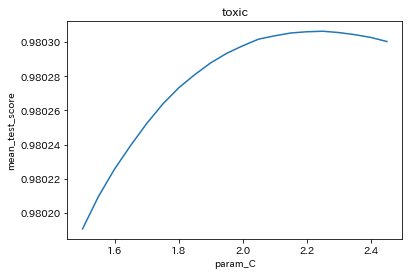

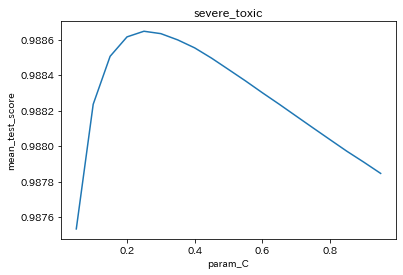

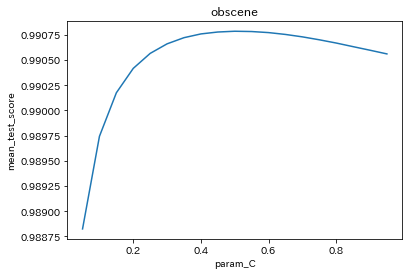

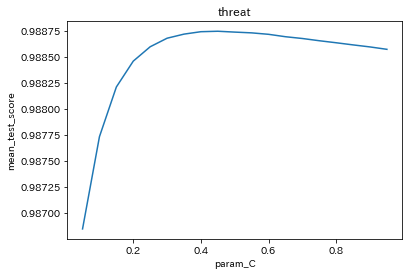

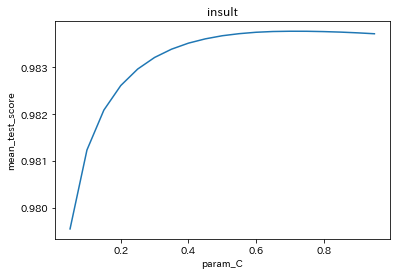

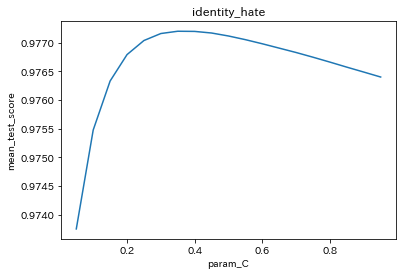

In [21]:
import pandas as pd

for i, j in enumerate(label_cols):
    #データフレーム化
    results=pd.DataFrame(model_list[i].cv_results_)
    
    plt.plot(results['param_C'],results['mean_test_score'])
    plt.title(j)
    plt.xlabel('param_C')
    plt.ylabel('mean_test_score')
    plt.show()